## 线性回归

本实验主要介绍使用MindSpore在模拟数据上进行线性回归实验，分析自变量和因变量之间的线性关系，即求得一个线性函数。

## 1、实验目的

- 了解线性回归的基本概念和问题模拟；
- 了解如何使用MindSpore进行线性回归实验。

## 2、简单线性回归模型原理

线性回归假设是指预测值可以表示为输入特征的加权和，如下面的式子：

$$ \hat y  = \sum_{i=1}^{n}{w_{i} * x_{i}} + b$$

式中的$n$表示输入特征个数，$i$表示具体的某个特征；$w_{i}$
称为对应特征的权重（weight），权重决定了每个特征对预测值的影响。 
$b$称为偏置（bias）、偏移量（offset）或截距（intercept）。偏置是指当所有特征都取值为0时，预测值应该为多少。式中$\hat y$是输入特征的一个仿射变换（affine transformation）。仿射变换的特点是通过加权和对特征进行线性变换（linear transformation）， 并通过偏置项来进行平移（translation）。

总之，给定一个数据集，线性回归模型的最终目的是为了寻找模型的一组权重$w$和偏置$b$， 使得模型预测大体符合数据的整体变化趋势。即输出的预测值由输入特征通过线性模型的仿射变换决定，仿射变换由所选权重和偏置确定。

## 3、实验环境

- MindSpore 2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。
- 如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4、数据处理

### 4.1、数据准备

###### 模块导入：

在生成数据之前，导入需要的Python库。

目前使用到os库，为方便理解，其他需要的库，我们在具体使用到时再说明。

详细的MindSpore的模块说明，可以在MindSpore API页面中搜索查询。

可以通过context.set_context来配置运行需要的信息，譬如运行模式、后端信息、硬件等信息。

导入context模块，配置运行需要的信息。

In [1]:
import os
from PIL import Image
import numpy as np
import mindspore as ms
from mindspore import nn, context, Tensor, ops
from mindspore.dataset import transforms, vision, GeneratorDataset

#context.set_context(mode=context.GRAPH_MODE, device_target="Ascend") #使用昇腾算力
context.set_context(mode=context.PYNATIVE_MODE, device_target="CPU")      #使用本地CPU算力

### 4.2、数据生成与加载
根据以下线性函数生成模拟数据，并在其中加入少许扰动（$noise$）。

$$y = -5 * x + 0.1 * noise$$

In [2]:
# Iterable object as input source
class Iterable:
    def __init__(self):
        self._data = np.arange(-5, 5, 0.3)[:32].reshape((32, 1))
        self._label = -5 * self._data +  0.1 * np.random.normal(loc=0.0, scale=20.0, size=self._data.shape)

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)

data = Iterable()
dataset = GeneratorDataset(source=data, column_names=["data", "label"])

## 5 模型构建
使用MindSpore提供的[`nn.Dense(1, 1)`算子](https://www.mindspore.cn/docs/zh-CN/r2.0.0-alpha/api_python/nn/mindspore.nn.Dense.html?highlight=dense#mindspore.nn.Dense)作为线性模型，其中`(1, 1)`表示线性模型的输入和输出皆是1维，即$w$是1x1的矩阵。算子会随机初始化权重$w$和偏置$b$。

$$y = w * x + b$$

采用均方差（Mean Squared Error, MSE）作为损失函数。

采用随机梯度下降（Stochastic Gradient Descent, SGD）对模型进行优化。

###### 定义模型训练函数

首先需要实例化回归模型、定义损失函数和优化器。由于需要使用函数式自动微分，需要将神经网络和损失函数的调用封装为一个前向计算函数。完成后，使用value_and_grad接口获得微分函数，用于计算梯度。定义train_step函数，计算梯度并用于优化，返回损失。

In [3]:
net = nn.Dense(1, 1)
loss_fn = nn.MSELoss()
opt = nn.SGD(net.trainable_params(), learning_rate=0.01)
def train_loop(model, dataset, loss_fn, optimizer):
    # 定义前向传播函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # 获得梯度函数
    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # 定义one-step训练函数
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss
    # 返回一个epoch中的batch数。
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data.astype(ms.float32), label.astype(ms.float32))
        if batch % 10 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

## 6、模型训练

In [4]:
epochs = 20
batch_size = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(net, dataset, loss_fn, opt)
print("Done!")

Epoch 1
-------------------------------
loss: 349.895294  [  0/ 32]
loss: 3.174734  [ 10/ 32]
loss: 0.120423  [ 20/ 32]
loss: 5.177361  [ 30/ 32]
Epoch 2
-------------------------------
loss: 2.999501  [  0/ 32]
loss: 5.514374  [ 10/ 32]
loss: 1.425277  [ 20/ 32]
loss: 0.272414  [ 30/ 32]
Epoch 3
-------------------------------
loss: 3.029483  [  0/ 32]
loss: 0.130504  [ 10/ 32]
loss: 0.022555  [ 20/ 32]
loss: 5.014421  [ 30/ 32]
Epoch 4
-------------------------------
loss: 0.189925  [  0/ 32]
loss: 3.365045  [ 10/ 32]
loss: 5.772472  [ 20/ 32]
loss: 4.572873  [ 30/ 32]
Epoch 5
-------------------------------
loss: 5.095932  [  0/ 32]
loss: 0.000492  [ 10/ 32]
loss: 3.998581  [ 20/ 32]
loss: 1.787967  [ 30/ 32]
Epoch 6
-------------------------------
loss: 2.757055  [  0/ 32]
loss: 17.401827  [ 10/ 32]
loss: 0.363621  [ 20/ 32]
loss: 3.723809  [ 30/ 32]
Epoch 7
-------------------------------
loss: 6.733719  [  0/ 32]
loss: 2.787441  [ 10/ 32]
loss: 0.535670  [ 20/ 32]
loss: 4.063876 

## 7、模型预测

###### 查看模型参数

可以查看参数的名称、维度、数据类型、数值以及是否求导（当requires_grad=True时，参数需要求导，进行反向传播）。

In [5]:
net.trainable_params()

[Parameter (name=weight, shape=(1, 1), dtype=Float32, requires_grad=True),
 Parameter (name=bias, shape=(1,), dtype=Float32, requires_grad=True)]

In [6]:
net.trainable_params()[0]

Parameter (name=weight, shape=(1, 1), dtype=Float32, requires_grad=True)

In [7]:
net.trainable_params()[0].asnumpy()

array([[-5.2449307]], dtype=float32)

###### 模型预测

训练一定的代数后，得到的模型已经十分接近真实的线性函数了。

In [8]:
wb = [x.asnumpy() for x in net.trainable_params()]
w, b = np.squeeze(wb[0]), np.squeeze(wb[1])
print('The true linear function is y = -5 * x + 0.1')
print('The trained linear model is y = {0} * x + {1}'.format(w, b))

for i in range(-10, 11, 5):
    print('x = {0}, predicted y = {1}'.format(i, net(ms.Tensor([[i]], ms.float32))))

The true linear function is y = -5 * x + 0.1
The trained linear model is y = -5.244930744171143 * x + 0.08946116268634796
x = -10, predicted y = [[52.53877]]
x = -5, predicted y = [[26.314114]]
x = 0, predicted y = [[0.08946116]]
x = 5, predicted y = [[-26.135193]]
x = 10, predicted y = [[-52.359844]]


###### 预测结果可视化

模拟的样本数据、真实的线性函数和训练得到的线性模型如下图所示：

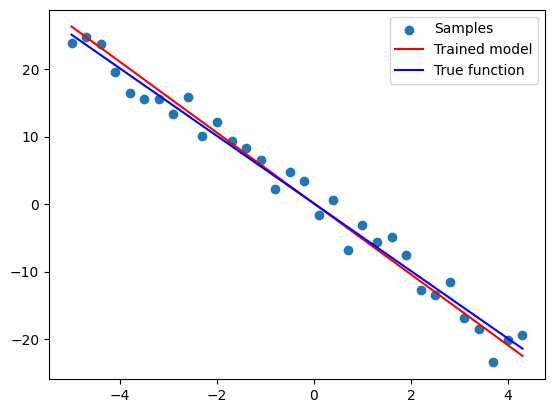

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

x = np.arange(-5, 5, 0.3)[:32].reshape((32, 1))
y = -5 * x +  0.1 * np.random.normal(loc=0.0, scale=20.0, size=x.shape)
plt.scatter(x, y, label='Samples')
plt.plot(x, w * x +  b, c='r', label='Trained model')
plt.plot(x, -5 * x + 0.1, c='b', label='True function')
plt.legend()